In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread, imsave
import cPickle as pickle
import yaml
import collections
from tqdm import tqdm
import time
from scipy.ndimage.interpolation import zoom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import lasagne
import lasagne.layers
import theano
import theano.tensor as T

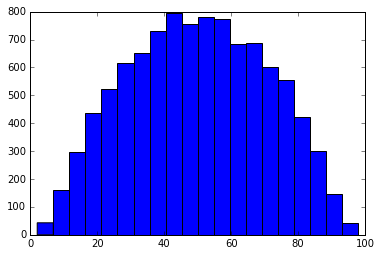

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sps = np.random.randn(10000) * 1
sps = 100*sigmoid(sps)
plt.hist(sps, 20);

In [210]:
class NormalisationLayer(lasagne.layers.MergeLayer):
    def __init__(self, incomings, **kwargs):
        super(NormalisationLayer, self).__init__(incomings, **kwargs)
        # no parameters to define

    def get_output_for(self, input, **kwargs):
        
        x, medians = input
        flattened = x.flatten(3)  # BxCxHxW --> BxCxHW
        
        # Rescaling each channel to be between 0 and 1
        A = flattened - flattened.min(2, keepdims=True)
        A = A / (A.max(2, keepdims=True) + 0.000001)
        A = A.reshape(x.shape)
        
        # Subtracting logged median from each channel
        B = x - medians
        
        # Whitening each spectrogram
        C = flattened - flattened.mean(2, keepdims=True)
        C = C / (C.std(2, keepdims=True) + 0.0000001)
        C = C.reshape(x.shape)

        # Whitening each row of each spectrogram
        D = x - x.mean(3, keepdims=True)
        D = D / (D.std(3, keepdims=True) + 0.0000001)
        
        return T.concatenate((A, B, C, D), axis=1)
        
    def get_output_shape_for(self, input_shapes):
        input_shape = input_shapes[0]
        return (input_shape[0], 4 * input_shape[1], input_shape[2], input_shape[3])

## Testing normalisaing layer

In [211]:
from lasagne.layers import InputLayer, DimshuffleLayer

net = InputLayer((None, 1, 2, 2))
med_net = InputLayer((None, 1, 2))
med_broadcastable = DimshuffleLayer(med_net, (0, 1, 2, 'x'))
out = NormalisationLayer((net, med_broadcastable))
print out.output_shape, med_broadcastable.output_shape
out_var = lasagne.layers.get_output(out)

(None, 4, 2, 2) (None, 1, 2, 1)


In [212]:
fn = theano.function([net.input_var, med_net.input_var], out_var, on_unused_input='ignore')

In [213]:
np.random.seed(10)
x = np.random.rand(*(1, 1, 3, 2))
meds = np.zeros((1, 1, 3)) + np.array((0, 1, 2))
print meds

x = x.astype(np.float32)
meds = meds.astype(np.float32)

print x
print
normed = fn(x, meds)
print normed

[[[ 0.  1.  2.]]]
[[[[ 0.77132064  0.02075195]
   [ 0.63364822  0.74880385]
   [ 0.49850702  0.22479665]]]]

[[[[ 0.99999863  0.        ]
   [ 0.81657475  0.96999902]
   [ 0.63652325  0.27185309]]

  [[ 0.77132064  0.02075195]
   [-0.36635178 -0.25119615]
   [-1.50149298 -1.77520335]]

  [[ 1.04474103 -1.67470372]
   [ 0.54592919  0.96315873]
   [ 0.05628845 -0.93541324]]

  [[ 0.9999997  -0.9999997 ]
   [-0.99999774  0.99999881]
   [ 0.99999917 -0.99999917]]]]


## Testing logging layer

In [259]:
class LearnLogLayer(lasagne.layers.Layer):
    """Learn the parameters of a logarithm log(Ax + B), repeated multiple times...
    
    Assumes input is of shape None x 1 x H x W"""
    
    def __init__(self, incoming, num_repeats, A=lasagne.init.Normal(), 
                 B=lasagne.init.Normal(), **kwargs):
        super(LearnLogLayer, self).__init__(incoming, **kwargs)
        self.num_repeats = num_repeats
        self.A = self.add_param(A, (1, num_repeats, 1, 1), name='A')
        self.B = self.add_param(B, (1, num_repeats, 1, 1), name='B')

    def get_output_for(self, input, **kwargs):
        # Using sigmoids to contrain A and B. Could use exp if want 
        # unbounded upper limit. Also, this might be undercontrained
        # right now.
        _A = T.nnet.sigmoid(self.A) * 100 + 0.000001
        _B = T.nnet.sigmoid(self.B) * 100 + 0.000001
        
        # big hack to make input broadcastable...
        input = input[:, 0, :, :][:, None, :, :]

        return T.log(_A * input + _B)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.num_repeats, input_shape[2], input_shape[3])

In [260]:
from lasagne.layers import InputLayer, DimshuffleLayer

# tensortype = T.TensorType('float32', (False, True, False, False))

# inp = tensortype((None, 1, 2, 2))
net = InputLayer((None, 1, 2, 2))#, input_var=inp)
out = LearnLogLayer(net, 10)
print out.output_shape
out_var = lasagne.layers.get_output(out)

(None, 10, 2, 2)


In [261]:
fn = theano.function([net.input_var], out_var, on_unused_input='ignore')

In [266]:
print x
print fn(x)

[[[[ 0.77132064  0.02075195]
   [ 0.63364822  0.74880385]
   [ 0.49850702  0.22479665]]]]
[[[[ 4.49184752  3.9381187 ]
   [ 4.41064692  4.47901011]
   [ 4.32396269  4.12135458]]

  [[ 4.48544645  3.93436074]
   [ 4.40454817  4.47265482]
   [ 4.31821489  4.11655664]]

  [[ 4.48629379  3.93368816]
   [ 4.40522146  4.47347546]
   [ 4.31868601  4.11648178]]

  [[ 4.4833827   3.93187284]
   [ 4.40243578  4.47058392]
   [ 4.31604624  4.1142354 ]]

  [[ 4.4863615   3.93348455]
   [ 4.40525818  4.4735384 ]
   [ 4.31868696  4.11638498]]

  [[ 4.48089027  3.93639469]
   [ 4.40074968  4.46821451]
   [ 4.31529474  4.11600494]]

  [[ 4.48403311  3.93618846]
   [ 4.40350676  4.47129822]
   [ 4.3176055   4.11711121]]

  [[ 4.48545647  3.93684459]
   [ 4.4048419   4.47270823]
   [ 4.31883812  4.11806822]]

  [[ 4.4841876   3.93145776]
   [ 4.40310144  4.47136784]
   [ 4.31654978  4.11430025]]

  [[ 4.4822154   3.92919135]
   [ 4.40109491  4.46938992]
   [ 4.31450415  4.11214924]]]]
